## Importing relevant modules

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt


## Importing Dataset

In [3]:
train_dir = r"..\Skin cancer_Binary Classification\Skin cancer dataset\train"
test_dir = r"..\Skin cancer_Binary Classification\Skin cancer dataset\test"

In [4]:
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_test = sum([len(files) for r, d, files in os.walk(test_dir)])

In [5]:
print(total_train)
print(total_test)

2078
660


In [6]:
batch_size = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224

## Preparing the dataset for the model and using data augmenting for smaller dataset size

In [7]:
train_image_generator = ImageDataGenerator(rescale= 1./255,
                                           horizontal_flip= True,
                                           zoom_range = 0.3,
                                           rotation_range = 15.,
                                           validation_split= 0.2,
                                          )
test_image_generator = ImageDataGenerator(rescale=1./255,
                                         )

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes = ('malignant', 'benign'),
                                                           subset='training'
                                                           )
val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                         directory=train_dir,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='categorical',
                                                         classes = ('malignant', 'benign'),
                                                         subset='validation'
                                                        )

test_data_gen = test_image_generator.flow_from_directory(batch_size=1, 
                                                         directory=test_dir,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode=None,
                                                         shuffle=False,
                                                         classes = ('malignant', 'benign')
                                                        )

Found 1662 images belonging to 2 classes.
Found 415 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


## Taking a look at the dataset

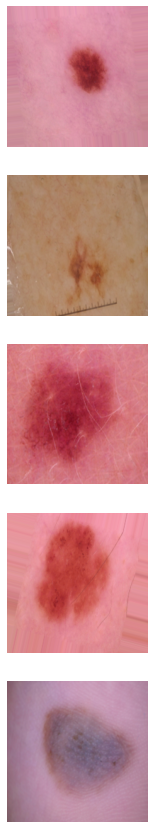

In [8]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% malignant")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% benign")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [8]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

## Calling the pretrained model

In [9]:
base_model = tf.keras.applications.VGG16(weights='imagenet', 
                   include_top = False,
                   input_shape = (224,224,3)
                  )

base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Adding the classiication head

In [10]:
from tensorflow.keras import layers, models

s = tf.keras.layers.GlobalMaxPooling2D()
u = tf.keras.layers.Dense(4096, activation='relu')
y = tf.keras.layers.Dense(1072, activation='relu')
pred = tf.keras.layers.Dense(2, activation='softmax')

model = models.Sequential([base_model, 
                          s,
                          u,
                          y,
                          pred 
                          ])

## Compiling the model

In [11]:
model.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 1072)              4391984   
                                                                 
 dense_2 (Dense)             (None, 2)                 2146      
                                                                 
Total params: 21,210,066
Trainable params: 6,495,378
Non-trainable params: 14,714,688
____________________________________

## Training the model

In [15]:
cp = tf.keras.callbacks.ModelCheckpoint('vgg16_1.h5',
                                        monitor = 'val_accuracy',
                                        save_best_only=True,
                                        verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'accuracy',
    mode = 'max',
    patience = 8
)

history = model.fit(
    train_data_gen, 
    validation_data = val_data_gen,
    workers = 2,
    epochs=50,
    callbacks = [cp, early_stopping]
)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.4230 - accuracy: 0.7912
Epoch 1: val_accuracy improved from -inf to 0.75663, saving model to vgg16_1.h5
26/26 [==============================] - 20s 748ms/step - loss: 0.4230 - accuracy: 0.7912 - val_loss: 0.4535 - val_accuracy: 0.7566
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.3889 - accuracy: 0.8111
Epoch 2: val_accuracy improved from 0.75663 to 0.78795, saving model to vgg16_1.h5
26/26 [==============================] - 20s 750ms/step - loss: 0.3889 - accuracy: 0.8111 - val_loss: 0.4059 - val_accuracy: 0.7880
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.3875 - accuracy: 0.8087
Epoch 3: val_accuracy did not improve from 0.78795
26/26 [==============================] - 20s 752ms/step - loss: 0.3875 - accuracy: 0.8087 - val_loss: 0.4208 - val_accuracy: 0.7880
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 0.3575 - accuracy: 0.8255
Epoch 4: val_a

## Visualizing the training

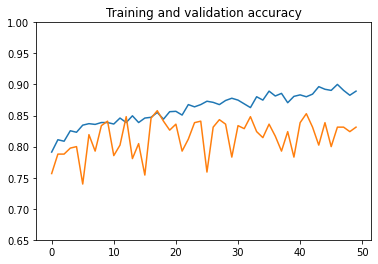

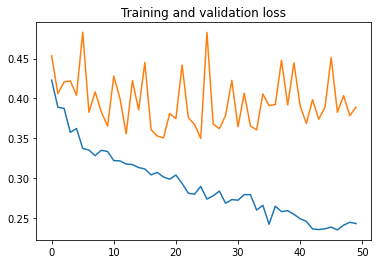

In [16]:
plot_history(history, (0.65, 1)) 

## Saving and pre-loading

In [9]:
# import pickle

# # with open('/trainHistoryDict', 'wb') as file_pi:
# #         pickle.dump(history.history, file_pi)

# #load history
# history = pickle.load(open('/trainHistoryDict', "rb"))

filename = 'saved_model.sav'
# pickle.dump(model, open(filename, 'wb'))

#load model
#model = pickle.load(open(filename, 'rb'))

# model.save('E:\Abhyaas\SEM VIII\BIO402 (Lab Project)\Skin cancer_Binary Classification')
model = tf.keras.models.load_model(r"E:\Abhyaas\SEM VIII\BIO402 (Lab Project)\Skin cancer_Binary Classification")

In [9]:
predw = model.predict(test_data_gen, verbose = True)
predictedClassesw = np.where(predw>0.5, 1, 0)
predYw = np.argmax(predw, axis=1)


660/660 [==============================] - 17s 17ms/step


## Using confusion matrix to visualize model performance

              precision    recall  f1-score   support

      Benign       0.79      0.84      0.81       300
   Malignant       0.86      0.81      0.84       360

    accuracy                           0.83       660
   macro avg       0.82      0.83      0.83       660
weighted avg       0.83      0.83      0.83       660



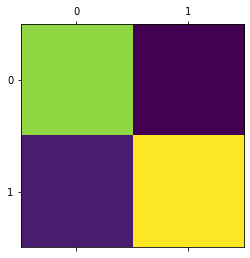

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
plt.matshow(confusion_matrix(test_data_gen.classes, predYw>0.5))
print(classification_report(test_data_gen.classes, predYw>0.5, target_names = ['Benign', 'Malignant']))

[[252  48]
 [ 67 293]]


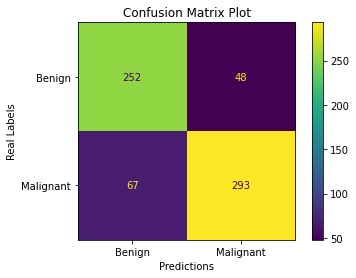

In [12]:
cm = confusion_matrix(test_data_gen.classes, predYw>0.5)
## Print the Confusion Matrix.
print(cm)
## Create the Confusion Matrix Display Object(cmd_obj). Note the 
## alphabetical sorting order of the labels.
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Benign', 'Malignant'])
## The plot() function has to be called for the sklearn visualization
## code to do its work and the Axes object to be created.
cmd_obj.plot()
## Use the Axes attribute 'ax_' to get to the underlying Axes object.
## The Axes object controls the labels for the X and the Y axes. It
## also controls the title.
cmd_obj.ax_.set(
                title='Confusion Matrix Plot', 
                xlabel='Predictions', 
                ylabel='Real Labels')
## Finally, call the matplotlib show() function to display the visualization
## of the Confusion Matrix.
plt.show()

## Predicitons

[[0.8110379  0.18896209]]
Beningn with probability 81.10378980636597. You're safe (probably).


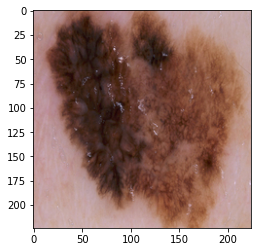

In [54]:
from keras.preprocessing import image
from keras.models import load_model
#saved_model = load_model("E:\Abhyaas\SEM VIII\BIO402 (Lab Project)\Skin cancer_Binary Classification\VGG_Skin_Classifier.h5")

img = image.load_img(r"E:\Abhyaas\SEM VIII\BIO402 (Lab Project)\Skin cancer_Binary Classification\Skin cancer dataset\train\malignant\867.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = x / 255
x = np.expand_dims(x, axis=0)
plt.imshow(img)
classes = model.predict(x)
print(classes)
if classes[0][0] >= 0.5:
    print("Beningn " + "with probability " + str(classes[0][0]*100) + ". You're safe (probably).")
else:
    print("Malignant " + "with probability " + str(classes[0][1]*100) + ". Damn.")

In [13]:
model.evaluate(val_data_gen)

7/7 [==============================] - 8s 949ms/step - loss: 0.3779 - accuracy: 0.8361


[0.37785401940345764, 0.8361445665359497]